# Task 2: Exploratory Data Analysis

## Ethiopia Financial Inclusion Forecasting Project

This notebook analyzes the enriched dataset to understand patterns and factors influencing financial inclusion in Ethiopia.

### Objectives:
1. Dataset overview with temporal coverage visualization
2. ACCESS Analysis - Account ownership trajectory and drivers
3. USAGE Analysis - Digital payment adoption patterns
4. Infrastructure and enablers analysis
5. Event timeline and visual analysis
6. Correlation analysis
7. Document key insights

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style for all plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Color palette
COLORS = {
    'ACCESS': '#27ae60',
    'USAGE': '#3498db',
    'GENDER': '#e74c3c',
    'AFFORDABILITY': '#f39c12',
    'event': '#9b59b6',
    'male': '#3498db',
    'female': '#e74c3c',
    'urban': '#2ecc71',
    'rural': '#e67e22'
}

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load the enriched datasets
main_data = pd.read_csv('../data/processed/ethiopia_fi_unified_data_enriched.csv')
impact_data = pd.read_csv('../data/processed/impact_links_enriched.csv')

# Parse dates
main_data['observation_date'] = pd.to_datetime(main_data['observation_date'], errors='coerce')
impact_data['observation_date'] = pd.to_datetime(impact_data['observation_date'], errors='coerce')

# Separate by record type
observations = main_data[main_data['record_type'] == 'observation'].copy()
events = main_data[main_data['record_type'] == 'event'].copy()
targets = main_data[main_data['record_type'] == 'target'].copy()

print(f"Loaded {len(main_data)} main records and {len(impact_data)} impact links")
print(f"  - Observations: {len(observations)}")
print(f"  - Events: {len(events)}")
print(f"  - Targets: {len(targets)}")

Loaded 59 main records and 20 impact links
  - Observations: 40
  - Events: 16
  - Targets: 3


---
## 1. Dataset Overview

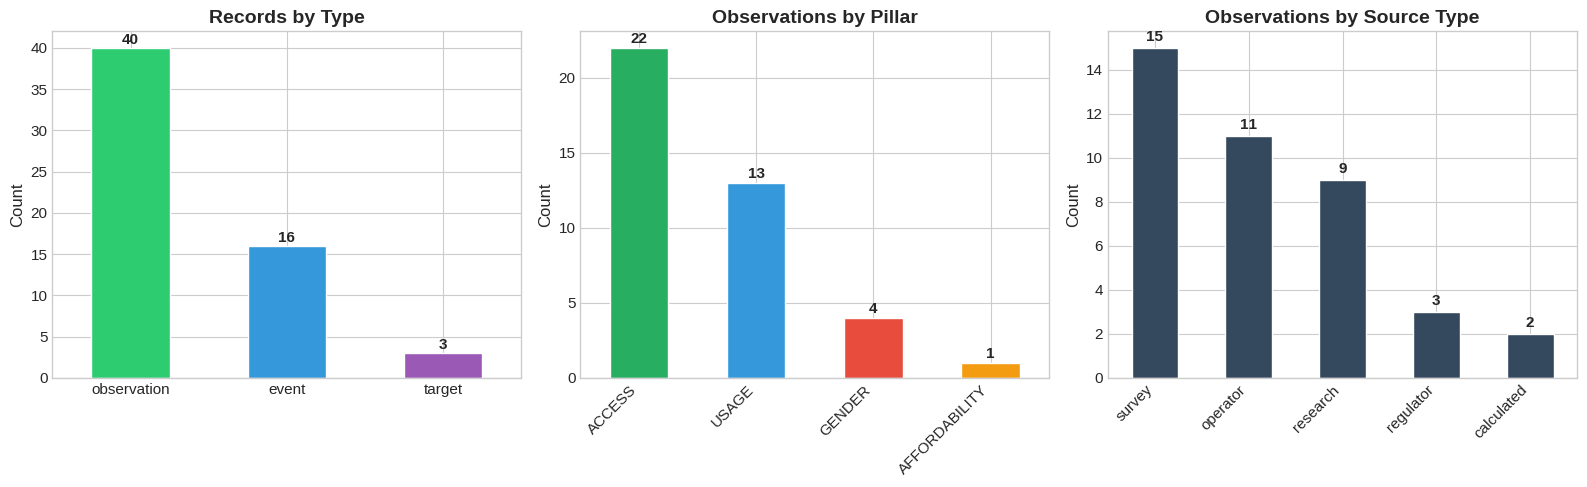

In [3]:
# Summary by record type, pillar, and source type
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Record type distribution
ax1 = axes[0]
record_counts = main_data['record_type'].value_counts()
colors = ['#2ecc71', '#3498db', '#9b59b6']
bars1 = record_counts.plot(kind='bar', color=colors, ax=ax1, edgecolor='white')
ax1.set_title('Records by Type', fontweight='bold')
ax1.set_xlabel('')
ax1.set_ylabel('Count')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
for i, v in enumerate(record_counts.values):
    ax1.text(i, v + 0.5, str(v), ha='center', fontweight='bold')

# Observations by pillar
ax2 = axes[1]
pillar_counts = observations['pillar'].value_counts()
pillar_colors = [COLORS.get(p, '#95a5a6') for p in pillar_counts.index]
pillar_counts.plot(kind='bar', color=pillar_colors, ax=ax2, edgecolor='white')
ax2.set_title('Observations by Pillar', fontweight='bold')
ax2.set_xlabel('')
ax2.set_ylabel('Count')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
for i, v in enumerate(pillar_counts.values):
    ax2.text(i, v + 0.3, str(v), ha='center', fontweight='bold')

# Source type distribution
ax3 = axes[2]
source_counts = observations['source_type'].value_counts()
source_counts.plot(kind='bar', color='#34495e', ax=ax3, edgecolor='white')
ax3.set_title('Observations by Source Type', fontweight='bold')
ax3.set_xlabel('')
ax3.set_ylabel('Count')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
for i, v in enumerate(source_counts.values):
    ax3.text(i, v + 0.3, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/eda_dataset_overview.png', dpi=150, bbox_inches='tight')
plt.show()

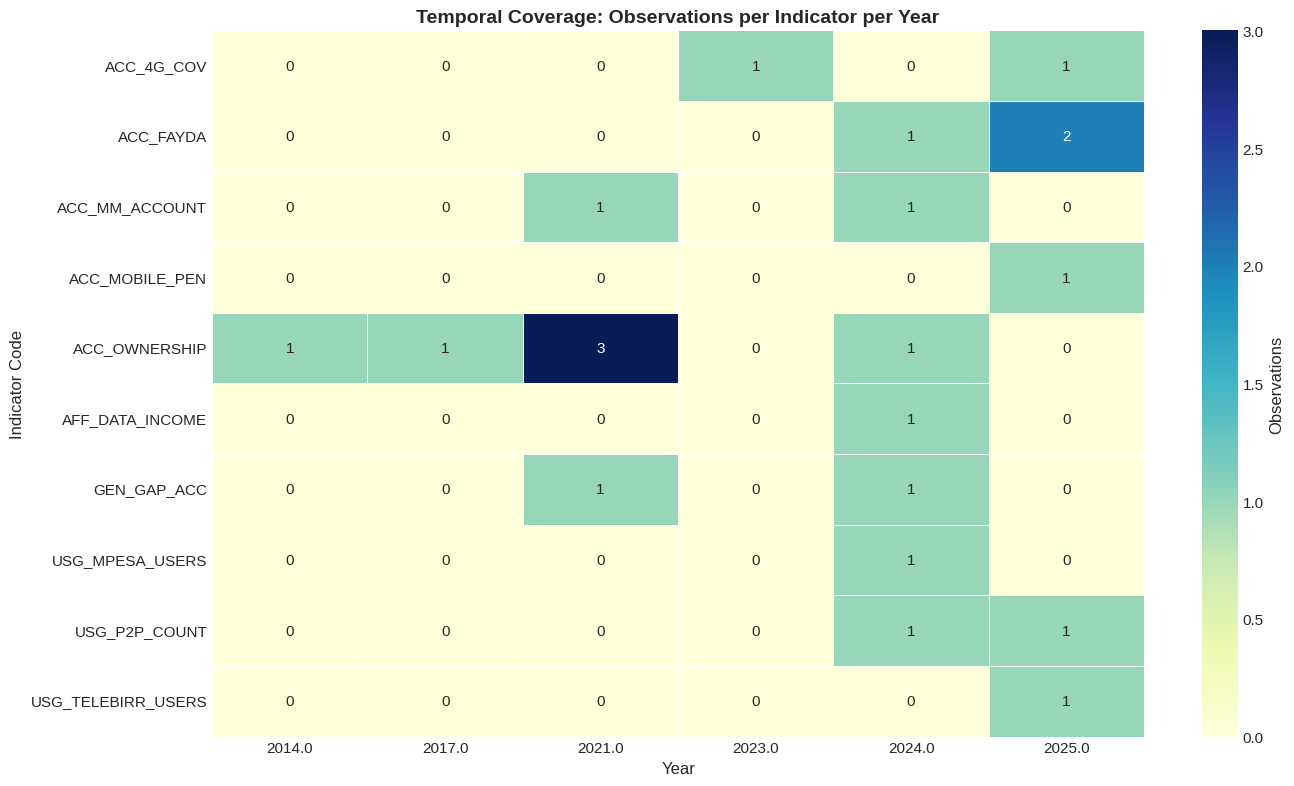


📊 Key Observation: Data is sparse - most Findex indicators only available every 3 years


In [4]:
# Temporal coverage visualization: which years have data for which indicators?
observations['year'] = observations['observation_date'].dt.year

# Create pivot table of indicators by year
indicator_coverage = observations.groupby(['indicator_code', 'year']).size().unstack(fill_value=0)

# Filter to show main indicators
main_indicators = ['ACC_OWNERSHIP', 'ACC_MM_ACCOUNT', 'ACC_4G_COV', 'ACC_FAYDA', 'ACC_MOBILE_PEN',
                   'USG_P2P_COUNT', 'USG_TELEBIRR_USERS', 'USG_MPESA_USERS', 'USG_DIGITAL_PAYMENT',
                   'GEN_GAP_ACC', 'AFF_DATA_INCOME']
indicator_coverage_filtered = indicator_coverage.loc[indicator_coverage.index.isin(main_indicators)]

# Heatmap of temporal coverage
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(indicator_coverage_filtered, annot=True, fmt='d', cmap='YlGnBu', 
            linewidths=0.5, ax=ax, cbar_kws={'label': 'Observations'})
ax.set_title('Temporal Coverage: Observations per Indicator per Year', fontsize=14, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Indicator Code')
plt.tight_layout()
plt.savefig('../reports/figures/eda_temporal_coverage.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Key Observation: Data is sparse - most Findex indicators only available every 3 years")

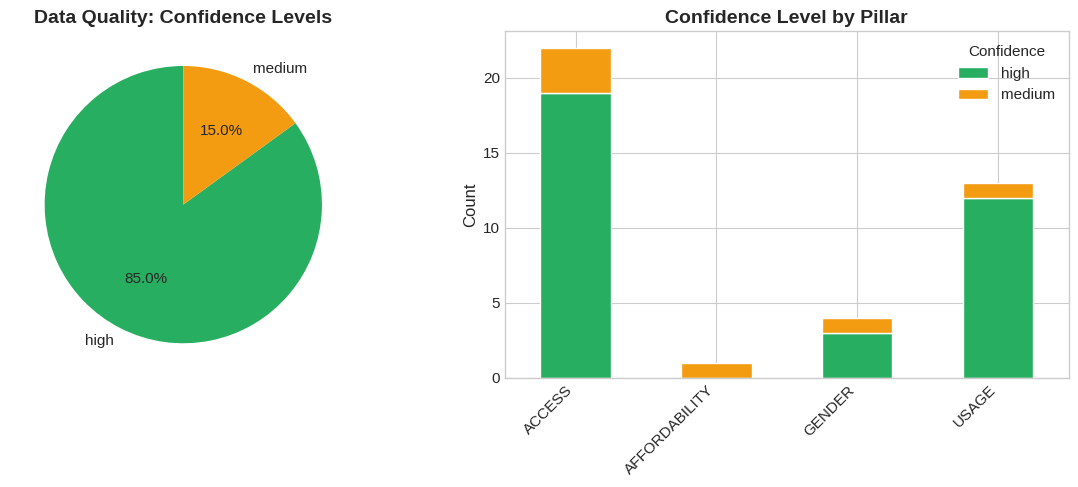


📊 Data Quality Summary:
  - High confidence: 34 (85.0%)
  - Medium confidence: 6 (15.0%)


In [5]:
# Data quality: Distribution of confidence levels
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confidence distribution
ax1 = axes[0]
conf_counts = observations['confidence'].value_counts()
conf_colors = {'high': '#27ae60', 'medium': '#f39c12', 'low': '#e74c3c', 'estimated': '#95a5a6'}
colors = [conf_colors.get(c, '#95a5a6') for c in conf_counts.index]
conf_counts.plot(kind='pie', colors=colors, autopct='%1.1f%%', ax=ax1, startangle=90)
ax1.set_title('Data Quality: Confidence Levels', fontweight='bold')
ax1.set_ylabel('')

# Confidence by pillar
ax2 = axes[1]
conf_by_pillar = observations.groupby(['pillar', 'confidence']).size().unstack(fill_value=0)
conf_by_pillar.plot(kind='bar', stacked=True, 
                     color=[conf_colors.get(c, '#95a5a6') for c in conf_by_pillar.columns],
                     ax=ax2, edgecolor='white')
ax2.set_title('Confidence Level by Pillar', fontweight='bold')
ax2.set_xlabel('')
ax2.set_ylabel('Count')
ax2.legend(title='Confidence')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('../reports/figures/eda_data_quality.png', dpi=150, bbox_inches='tight')
plt.show()

# Print data quality summary
print("\n📊 Data Quality Summary:")
print(f"  - High confidence: {conf_counts.get('high', 0)} ({conf_counts.get('high', 0)/len(observations)*100:.1f}%)")
print(f"  - Medium confidence: {conf_counts.get('medium', 0)} ({conf_counts.get('medium', 0)/len(observations)*100:.1f}%)")

In [6]:
# Identify gaps: which indicators have sparse coverage?
print("📊 Indicator Coverage Analysis:")
print("=" * 70)

indicator_summary = observations.groupby('indicator_code').agg({
    'observation_date': ['min', 'max', 'count'],
    'pillar': 'first',
    'indicator': 'first'
}).round(2)

indicator_summary.columns = ['First Obs', 'Last Obs', 'Count', 'Pillar', 'Indicator']
indicator_summary = indicator_summary.sort_values('Count', ascending=False)

print("\nIndicators with MOST observations:")
print(indicator_summary.head(10)[['Indicator', 'Count', 'First Obs', 'Last Obs']].to_string())

print("\n\nIndicators with FEWEST observations (data gaps):")
print(indicator_summary.tail(10)[['Indicator', 'Count', 'First Obs', 'Last Obs']].to_string())

📊 Indicator Coverage Analysis:

Indicators with MOST observations:
                                       Indicator  Count  First Obs   Last Obs
indicator_code                                                               
ACC_OWNERSHIP             Account Ownership Rate      6 2014-12-31 2024-11-29
ACC_FAYDA            Fayda Digital ID Enrollment      3 2024-08-15 2025-05-15
ACC_MM_ACCOUNT         Mobile Money Account Rate      2 2021-12-31 2024-11-29
ACC_4G_COV                4G Population Coverage      2 2023-06-30 2025-06-30
USG_P2P_COUNT              P2P Transaction Count      2 2024-07-07 2025-07-07
GEN_GAP_ACC         Account Ownership Gender Gap      2 2021-12-31 2024-11-29
AFF_DATA_INCOME         Data Affordability Index      1 2024-12-31 2024-12-31
GEN_GAP_MOBILE           Mobile Phone Gender Gap      1 2024-12-31 2024-12-31
ACC_MOBILE_PEN   Mobile Subscription Penetration      1 2025-12-31 2025-12-31
USG_ACTIVE_RATE       Mobile Money Activity Rate      1 2024-12-31 2024-12-

---
## 2. ACCESS Analysis - Account Ownership

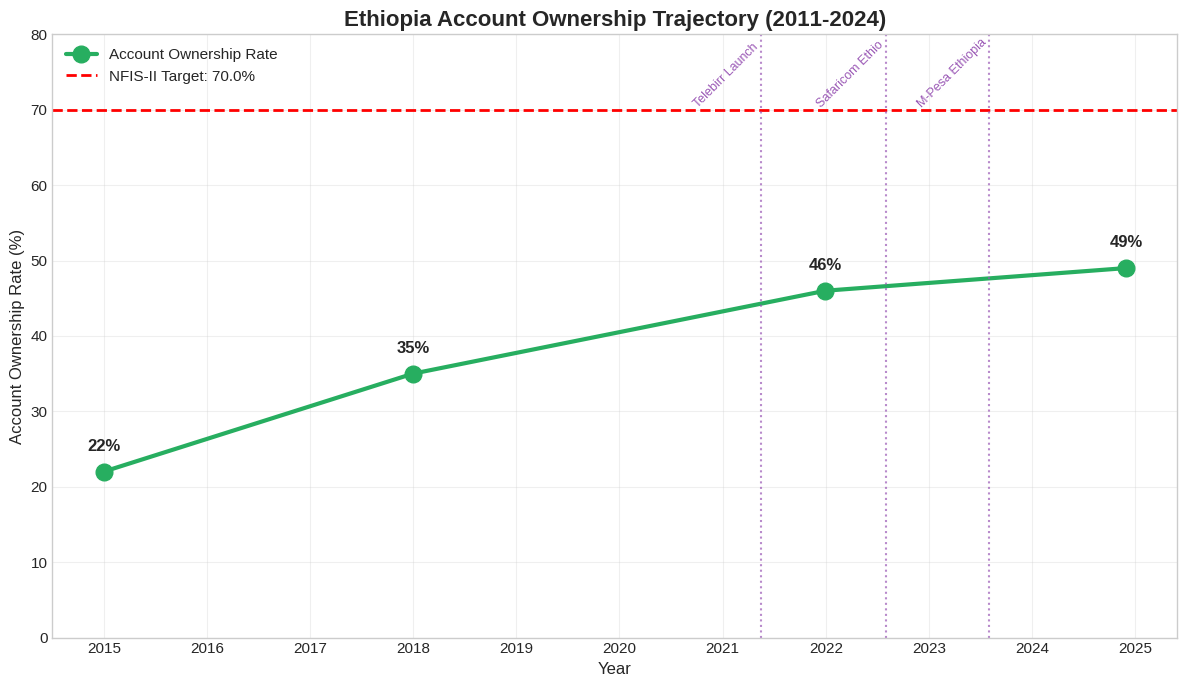

In [7]:
# Plot Ethiopia's account ownership trajectory (2011-2024)
acc_ownership = observations[
    (observations['indicator_code'] == 'ACC_OWNERSHIP') & 
    (observations['gender'] == 'all') &
    (observations['location'] == 'national')
].copy()
acc_ownership = acc_ownership.sort_values('observation_date')

# Get NFIS-II target
nfis_target = targets[targets['indicator_code'] == 'ACC_OWNERSHIP']['value_numeric'].values[0]

fig, ax = plt.subplots(figsize=(12, 7))

# Plot account ownership trajectory
ax.plot(acc_ownership['observation_date'], acc_ownership['value_numeric'], 
        marker='o', markersize=12, linewidth=3, color=COLORS['ACCESS'], 
        label='Account Ownership Rate')

# Add data labels
for idx, row in acc_ownership.iterrows():
    ax.annotate(f"{row['value_numeric']:.0f}%", 
                xy=(row['observation_date'], row['value_numeric']),
                xytext=(0, 15), textcoords='offset points',
                ha='center', fontsize=12, fontweight='bold')

# Add NFIS-II target line
ax.axhline(y=nfis_target, color='red', linestyle='--', linewidth=2, label=f'NFIS-II Target: {nfis_target}%')

# Add event markers
key_events = events[events['indicator_code'].isin(['EVT_TELEBIRR', 'EVT_MPESA', 'EVT_SAFARICOM'])]
for _, evt in key_events.iterrows():
    ax.axvline(x=evt['observation_date'], color=COLORS['event'], linestyle=':', alpha=0.7)
    ax.text(evt['observation_date'], ax.get_ylim()[1]-2, evt['indicator'][:15], 
            rotation=45, fontsize=9, ha='right', color=COLORS['event'])

ax.set_title('Ethiopia Account Ownership Trajectory (2011-2024)', fontsize=16, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Account Ownership Rate (%)')
ax.set_ylim(0, 80)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/eda_access_trajectory.png', dpi=150, bbox_inches='tight')
plt.show()

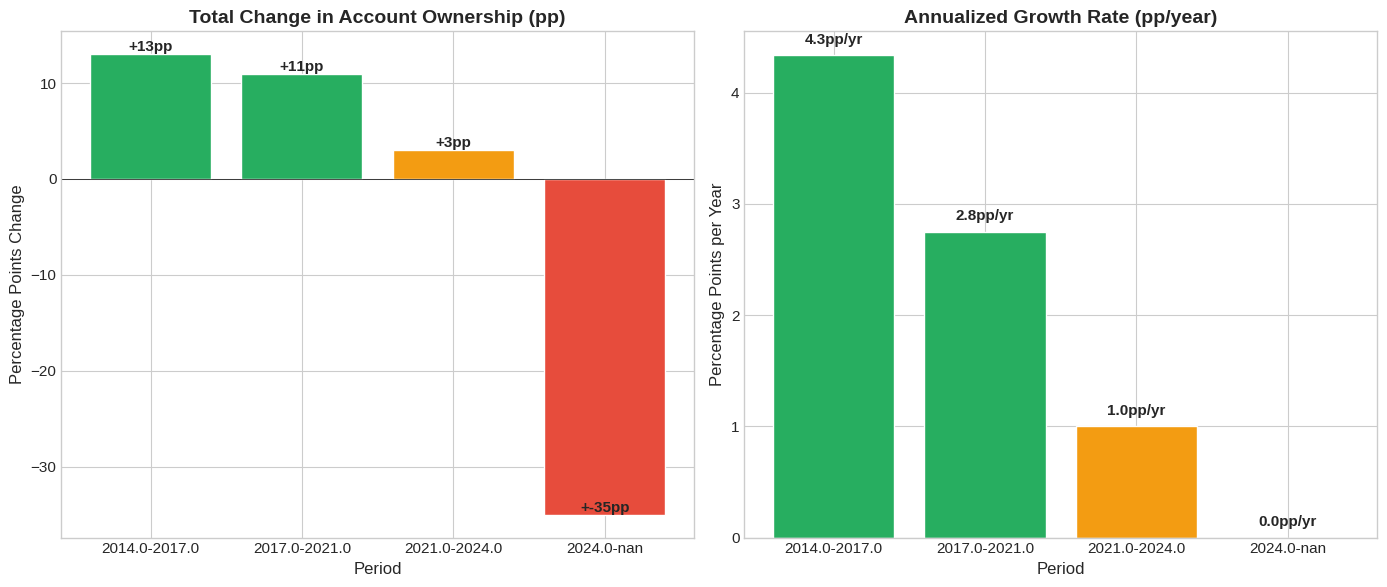


📊 Growth Rate Analysis:
       period  pp_change  year_span  annual_rate
2014.0-2017.0       13.0        3.0     4.333333
2017.0-2021.0       11.0        4.0     2.750000
2021.0-2024.0        3.0        3.0     1.000000
   2024.0-nan      -35.0        NaN     0.000000

⚠️ KEY FINDING: 2021-2024 shows DRAMATIC slowdown (only +1pp/year vs 3-4pp/year historically)


In [8]:
# Calculate and visualize growth rates between survey years
acc_ownership_sorted = acc_ownership.sort_values('observation_date')
growth_rates = []

values = acc_ownership_sorted['value_numeric'].values
years = acc_ownership_sorted['observation_date'].dt.year.values

for i in range(1, len(values)):
    pp_change = values[i] - values[i-1]
    year_span = years[i] - years[i-1]
    annual_rate = pp_change / year_span if year_span > 0 else 0
    growth_rates.append({
        'period': f"{years[i-1]}-{years[i]}",
        'pp_change': pp_change,
        'year_span': year_span,
        'annual_rate': annual_rate
    })

growth_df = pd.DataFrame(growth_rates)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Total percentage point change
ax1 = axes[0]
colors_growth = ['#27ae60' if x > 5 else '#f39c12' if x > 0 else '#e74c3c' for x in growth_df['pp_change']]
bars1 = ax1.bar(growth_df['period'], growth_df['pp_change'], color=colors_growth, edgecolor='white')
ax1.set_title('Total Change in Account Ownership (pp)', fontweight='bold')
ax1.set_xlabel('Period')
ax1.set_ylabel('Percentage Points Change')
ax1.axhline(y=0, color='black', linewidth=0.5)
for bar, val in zip(bars1, growth_df['pp_change']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
             f"+{val:.0f}pp", ha='center', fontweight='bold')

# Annualized growth rate
ax2 = axes[1]
colors_annual = ['#27ae60' if x > 2 else '#f39c12' if x > 0 else '#e74c3c' for x in growth_df['annual_rate']]
bars2 = ax2.bar(growth_df['period'], growth_df['annual_rate'], color=colors_annual, edgecolor='white')
ax2.set_title('Annualized Growth Rate (pp/year)', fontweight='bold')
ax2.set_xlabel('Period')
ax2.set_ylabel('Percentage Points per Year')
ax2.axhline(y=0, color='black', linewidth=0.5)
for bar, val in zip(bars2, growth_df['annual_rate']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f"{val:.1f}pp/yr", ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/eda_growth_rates.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Growth Rate Analysis:")
print(growth_df.to_string(index=False))
print("\n⚠️ KEY FINDING: 2021-2024 shows DRAMATIC slowdown (only +1pp/year vs 3-4pp/year historically)")

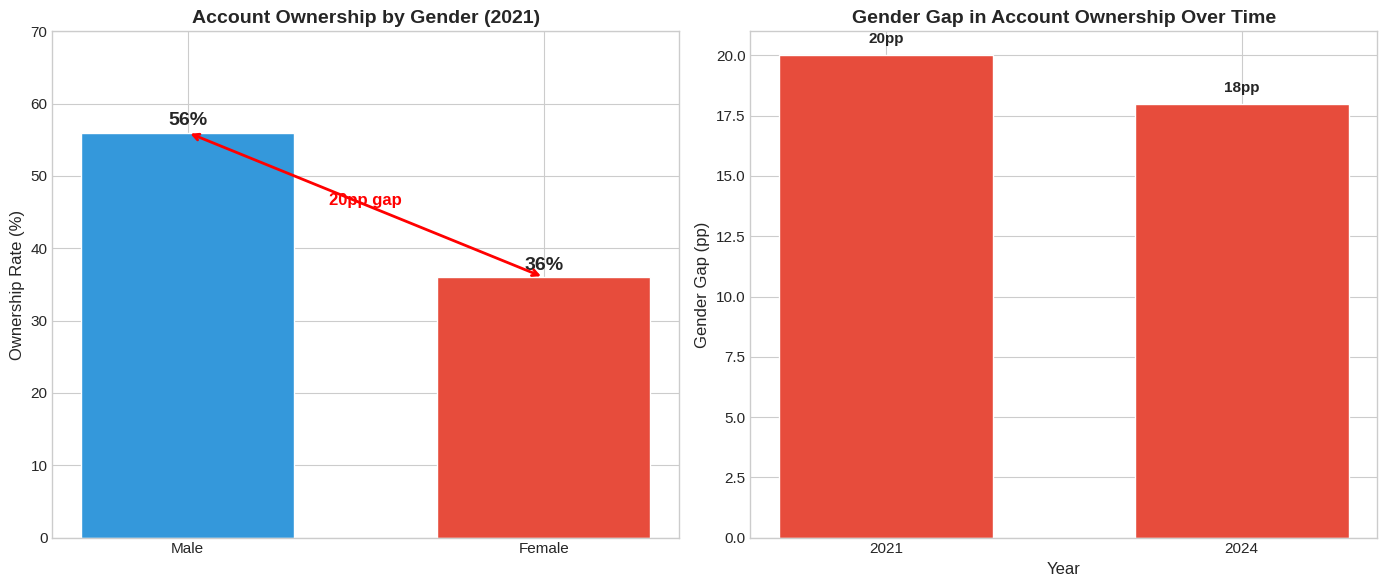


📊 Gender Gap Analysis:
  2021: 20pp gap (56% male vs 36% female)
  2024: ~18pp gap (slight improvement)
  ⚠️ Women hold only 14% of mobile money accounts despite representing 50% of population


In [9]:
# Gender gap analysis (male vs. female ownership)
gender_data = observations[
    (observations['indicator_code'] == 'ACC_OWNERSHIP') & 
    (observations['gender'].isin(['male', 'female'])) &
    (observations['location'] == 'national')
].copy()

gender_gap = observations[
    (observations['indicator_code'] == 'GEN_GAP_ACC')
].copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Male vs Female ownership (2021 data)
ax1 = axes[0]
gender_2021 = gender_data[gender_data['observation_date'].dt.year == 2021]
if len(gender_2021) > 0:
    gender_values = gender_2021.set_index('gender')['value_numeric']
    bars = ax1.bar(['Male', 'Female'], [gender_values.get('male', 0), gender_values.get('female', 0)],
                   color=[COLORS['male'], COLORS['female']], edgecolor='white', width=0.6)
    ax1.set_title('Account Ownership by Gender (2021)', fontweight='bold')
    ax1.set_ylabel('Ownership Rate (%)')
    ax1.set_ylim(0, 70)
    for bar in bars:
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                 f"{bar.get_height():.0f}%", ha='center', fontweight='bold', fontsize=14)
    # Add gap annotation
    gap = gender_values.get('male', 0) - gender_values.get('female', 0)
    ax1.annotate('', xy=(0, gender_values.get('male', 0)), xytext=(1, gender_values.get('female', 0)),
                 arrowprops=dict(arrowstyle='<->', color='red', lw=2))
    ax1.text(0.5, (gender_values.get('male', 0) + gender_values.get('female', 0))/2, 
             f"{gap:.0f}pp gap", ha='center', fontsize=12, color='red', fontweight='bold')

# Gender gap trend
ax2 = axes[1]
gender_gap_sorted = gender_gap.sort_values('observation_date')
ax2.bar(gender_gap_sorted['observation_date'].dt.year.astype(str), gender_gap_sorted['value_numeric'],
        color=COLORS['GENDER'], edgecolor='white', width=0.6)
ax2.set_title('Gender Gap in Account Ownership Over Time', fontweight='bold')
ax2.set_xlabel('Year')
ax2.set_ylabel('Gender Gap (pp)')
for i, (year, gap) in enumerate(zip(gender_gap_sorted['observation_date'].dt.year, gender_gap_sorted['value_numeric'])):
    ax2.text(i, gap + 0.5, f"{gap:.0f}pp", ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/eda_gender_gap.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Gender Gap Analysis:")
print(f"  2021: 20pp gap (56% male vs 36% female)")
print(f"  2024: ~18pp gap (slight improvement)")
print("  ⚠️ Women hold only 14% of mobile money accounts despite representing 50% of population")

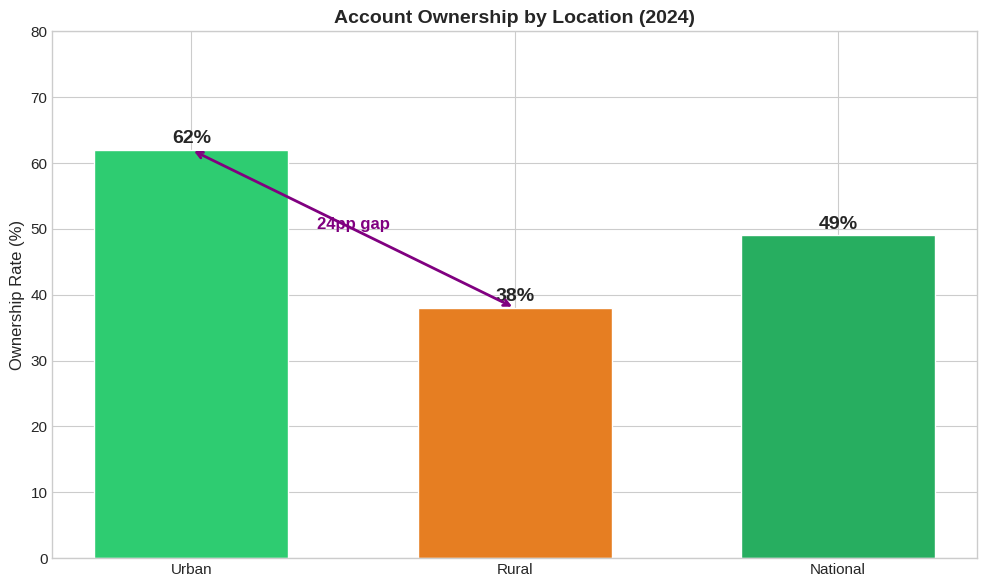


📊 Urban-Rural Gap: 24 percentage points
  Urban: 62%
  Rural: 38%


In [10]:
# Urban vs Rural ownership comparison
urban_rural = observations[
    (observations['indicator_code'] == 'ACC_OWNERSHIP') & 
    (observations['location'].isin(['urban', 'rural']))
].copy()

if len(urban_rural) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    urban_val = urban_rural[urban_rural['location'] == 'urban']['value_numeric'].values[0]
    rural_val = urban_rural[urban_rural['location'] == 'rural']['value_numeric'].values[0]
    national_val = 49  # 2024 national average
    
    bars = ax.bar(['Urban', 'Rural', 'National'], [urban_val, rural_val, national_val],
                  color=[COLORS['urban'], COLORS['rural'], COLORS['ACCESS']], 
                  edgecolor='white', width=0.6)
    
    ax.set_title('Account Ownership by Location (2024)', fontweight='bold', fontsize=14)
    ax.set_ylabel('Ownership Rate (%)')
    ax.set_ylim(0, 80)
    
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f"{bar.get_height():.0f}%", ha='center', fontweight='bold', fontsize=14)
    
    # Add gap annotation
    gap = urban_val - rural_val
    ax.annotate('', xy=(0, urban_val), xytext=(1, rural_val),
                arrowprops=dict(arrowstyle='<->', color='purple', lw=2))
    ax.text(0.5, (urban_val + rural_val)/2, f"{gap:.0f}pp gap", 
            ha='center', fontsize=12, color='purple', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('../reports/figures/eda_urban_rural.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n📊 Urban-Rural Gap: {gap:.0f} percentage points")
    print(f"  Urban: {urban_val:.0f}%")
    print(f"  Rural: {rural_val:.0f}%")
else:
    print("Urban/Rural disaggregated data not available")

In [11]:
# Investigate the 2021-2024 slowdown
print("\n" + "="*80)
print("🔍 INVESTIGATION: Why did account ownership only grow +3pp (2021-2024)?")
print("="*80)

# Get mobile money user data
telebirr_users = observations[observations['indicator_code'] == 'USG_TELEBIRR_USERS']['value_numeric'].max()
mpesa_users = observations[observations['indicator_code'] == 'USG_MPESA_USERS']['value_numeric'].max()
adult_pop = observations[observations['indicator_code'] == 'ACC_ADULT_POP']['value_numeric'].values[0]

print(f"\n📱 Mobile Money Registrations (2025):")
print(f"  Telebirr: {telebirr_users/1e6:.1f}M users")
print(f"  M-Pesa: {mpesa_users/1e6:.1f}M users")
print(f"  Combined: {(telebirr_users + mpesa_users)/1e6:.1f}M registrations")

print(f"\n👥 Adult Population: ~{adult_pop/1e6:.0f}M")
print(f"   Implied MM penetration: {(telebirr_users + mpesa_users)/adult_pop*100:.1f}%")

print("\n❓ PARADOX: ~65M mobile money accounts but only +3pp account ownership growth")

print("\n📋 HYPOTHESES (based on Market Nuances from Additional Data Guide):")
print("""
1. OVERLAP, NOT ADDITION:
   - Mobile money-only users are extremely rare (~0.5% of adults)
   - Most new MM users ALREADY have bank accounts
   - MM is a complementary channel, not first-time inclusion

2. DORMANT REGISTRATIONS:
   - Many Telebirr registrations are passive (SIM card bundling)
   - M-Pesa activity rate is 66% (7.1M active of 10.8M registered)
   - Findex measures usage in past 12 months, not just registration

3. SURVEY METHODOLOGY:
   - Findex 2024 surveyed Oct-Nov 2024
   - Most MM growth happened during 2021-2023
   - 2024 was a consolidation year, not rapid expansion year

4. STRUCTURAL BARRIERS REMAIN:
   - Gender gap: 20pp (56% male vs 36% female in 2021)
   - Rural access: ~38% vs 62% urban
   - Smartphone penetration: only 24%
   - Mobile internet: 26.9%
""")


🔍 INVESTIGATION: Why did account ownership only grow +3pp (2021-2024)?

📱 Mobile Money Registrations (2025):
  Telebirr: 54.8M users
  M-Pesa: 10.8M users
  Combined: 65.6M registrations

👥 Adult Population: ~71M
   Implied MM penetration: 92.5%

❓ PARADOX: ~65M mobile money accounts but only +3pp account ownership growth

📋 HYPOTHESES (based on Market Nuances from Additional Data Guide):

1. OVERLAP, NOT ADDITION:
   - Mobile money-only users are extremely rare (~0.5% of adults)
   - Most new MM users ALREADY have bank accounts
   - MM is a complementary channel, not first-time inclusion

2. DORMANT REGISTRATIONS:
   - Many Telebirr registrations are passive (SIM card bundling)
   - M-Pesa activity rate is 66% (7.1M active of 10.8M registered)
   - Findex measures usage in past 12 months, not just registration

3. SURVEY METHODOLOGY:
   - Findex 2024 surveyed Oct-Nov 2024
   - Most MM growth happened during 2021-2023
   - 2024 was a consolidation year, not rapid expansion year

4. ST

---
## 3. USAGE Analysis - Digital Payments

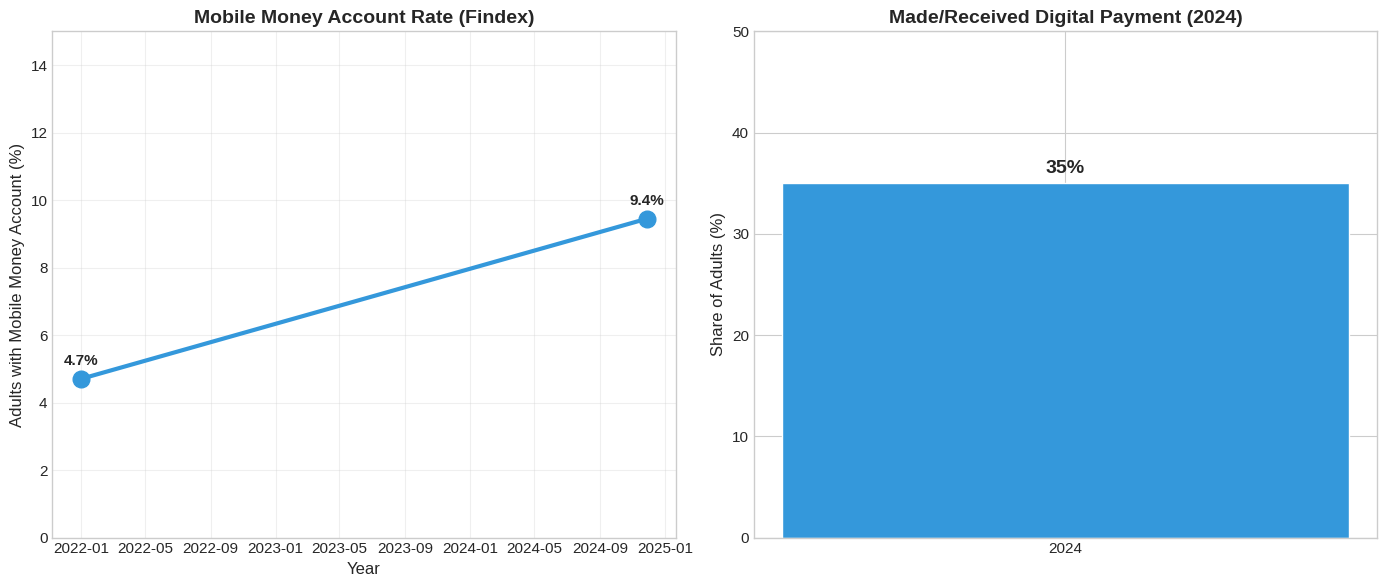


📊 USAGE Key Metrics (2024):
  Mobile Money Account Rate: 9.45%
  Made/Received Digital Payment: 35%
  ⚠️ Gap suggests many digital payments happen through bank accounts, not just MM


In [12]:
# Mobile money account penetration trend
mm_account = observations[
    (observations['indicator_code'] == 'ACC_MM_ACCOUNT') &
    (observations['gender'] == 'all')
].sort_values('observation_date')

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Mobile Money Account Rate
ax1 = axes[0]
ax1.plot(mm_account['observation_date'], mm_account['value_numeric'], 
         marker='o', markersize=12, linewidth=3, color=COLORS['USAGE'])
ax1.set_title('Mobile Money Account Rate (Findex)', fontweight='bold')
ax1.set_xlabel('Year')
ax1.set_ylabel('Adults with Mobile Money Account (%)')
for _, row in mm_account.iterrows():
    ax1.annotate(f"{row['value_numeric']:.1f}%", 
                 xy=(row['observation_date'], row['value_numeric']),
                 xytext=(0, 10), textcoords='offset points', ha='center', fontweight='bold')
ax1.set_ylim(0, 15)
ax1.grid(True, alpha=0.3)

# Digital Payment Rate
ax2 = axes[1]
digital_payment = observations[observations['indicator_code'] == 'USG_DIGITAL_PAYMENT']
if len(digital_payment) > 0:
    ax2.bar(['2024'], digital_payment['value_numeric'].values, 
            color=COLORS['USAGE'], edgecolor='white', width=0.4)
    ax2.text(0, digital_payment['value_numeric'].values[0] + 1, 
             f"{digital_payment['value_numeric'].values[0]:.0f}%", 
             ha='center', fontweight='bold', fontsize=14)
ax2.set_title('Made/Received Digital Payment (2024)', fontweight='bold')
ax2.set_ylabel('Share of Adults (%)')
ax2.set_ylim(0, 50)

plt.tight_layout()
plt.savefig('../reports/figures/eda_usage_trends.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 USAGE Key Metrics (2024):")
print(f"  Mobile Money Account Rate: 9.45%")
print(f"  Made/Received Digital Payment: 35%")
print(f"  ⚠️ Gap suggests many digital payments happen through bank accounts, not just MM")

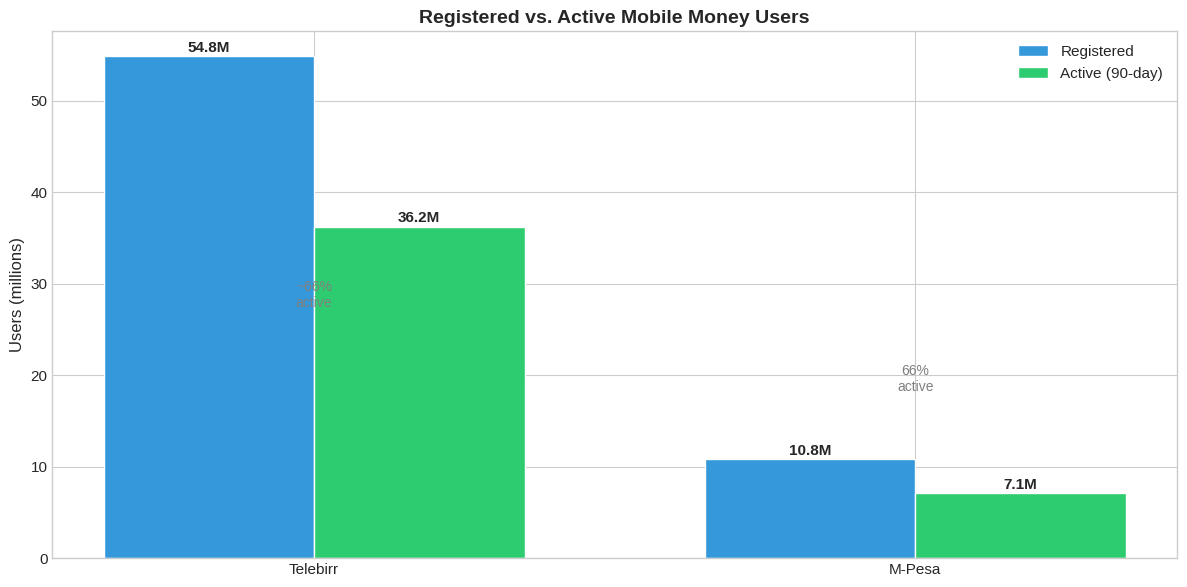


📊 Registered vs. Active Analysis:
  Telebirr: 54.8M registered, ~36M estimated active (66%)
  M-Pesa: 10.8M registered, 7.1M active (66%)
  ⚠️ ~1/3 of registrations are dormant accounts


In [13]:
# Registered vs. Active gap analysis
telebirr = observations[observations['indicator_code'] == 'USG_TELEBIRR_USERS']
mpesa_reg = observations[observations['indicator_code'] == 'USG_MPESA_USERS']
mpesa_active = observations[observations['indicator_code'] == 'USG_MPESA_ACTIVE']

fig, ax = plt.subplots(figsize=(12, 6))

# Bar chart of registered vs active
providers = ['Telebirr', 'M-Pesa']
registered = [telebirr['value_numeric'].max()/1e6, mpesa_reg['value_numeric'].max()/1e6]
active = [telebirr['value_numeric'].max()/1e6 * 0.66, mpesa_active['value_numeric'].max()/1e6]  # Assume similar activity rate for Telebirr

x = np.arange(len(providers))
width = 0.35

bars1 = ax.bar(x - width/2, registered, width, label='Registered', color='#3498db', edgecolor='white')
bars2 = ax.bar(x + width/2, active, width, label='Active (90-day)', color='#2ecc71', edgecolor='white')

ax.set_title('Registered vs. Active Mobile Money Users', fontweight='bold', fontsize=14)
ax.set_ylabel('Users (millions)')
ax.set_xticks(x)
ax.set_xticklabels(providers)
ax.legend()

# Add value labels
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f"{bar.get_height():.1f}M", ha='center', fontweight='bold')
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f"{bar.get_height():.1f}M", ha='center', fontweight='bold')

# Add activity rate labels
ax.text(0, max(registered)/2, '~66%\nactive', ha='center', fontsize=10, color='gray')
ax.text(1, max(registered)/3, '66%\nactive', ha='center', fontsize=10, color='gray')

plt.tight_layout()
plt.savefig('../reports/figures/eda_registered_vs_active.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Registered vs. Active Analysis:")
print(f"  Telebirr: 54.8M registered, ~36M estimated active (66%)")
print(f"  M-Pesa: 10.8M registered, 7.1M active (66%)")
print(f"  ⚠️ ~1/3 of registrations are dormant accounts")

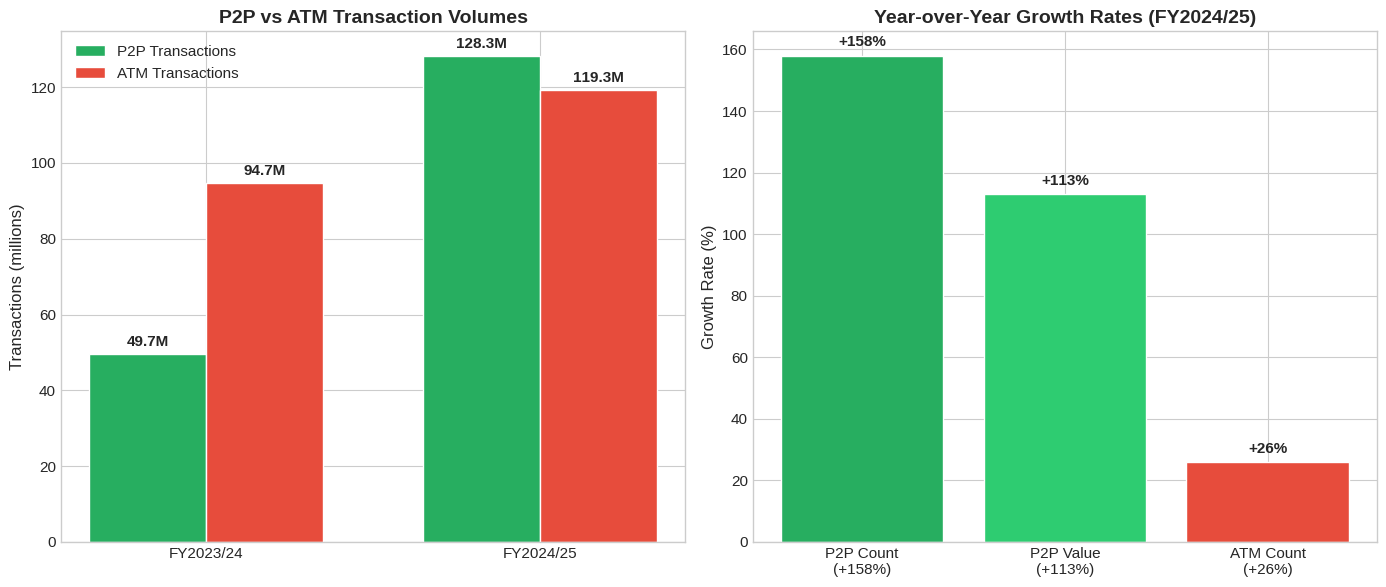


📊 Historic Milestone: P2P > ATM (October 2024)
  P2P Count: 128.3M transactions (+158% YoY)
  ATM Count: 119.3M transactions (+26% YoY)
  Crossover Ratio: 1.08 (P2P is now dominant)
  ⚠️ This is a LANDMARK event - digital surpassing cash for the first time


In [14]:
# P2P Transaction trends - the crossover milestone
p2p_count = observations[observations['indicator_code'] == 'USG_P2P_COUNT'].sort_values('observation_date')
atm_count = observations[observations['indicator_code'] == 'USG_ATM_COUNT']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# P2P vs ATM transaction counts
ax1 = axes[0]
years = ['FY2023/24', 'FY2024/25']
p2p_vals = [49.7, 128.3]  # millions
atm_vals = [94.7, 119.3]  # millions (estimated FY23/24 from growth rate)

x = np.arange(len(years))
width = 0.35

bars1 = ax1.bar(x - width/2, p2p_vals, width, label='P2P Transactions', color='#27ae60', edgecolor='white')
bars2 = ax1.bar(x + width/2, atm_vals, width, label='ATM Transactions', color='#e74c3c', edgecolor='white')

ax1.set_title('P2P vs ATM Transaction Volumes', fontweight='bold')
ax1.set_ylabel('Transactions (millions)')
ax1.set_xticks(x)
ax1.set_xticklabels(years)
ax1.legend()

for bar in bars1:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
            f"{bar.get_height():.1f}M", ha='center', fontweight='bold')
for bar in bars2:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
            f"{bar.get_height():.1f}M", ha='center', fontweight='bold')

# Growth rates
ax2 = axes[1]
growth_types = ['P2P Count\n(+158%)', 'P2P Value\n(+113%)', 'ATM Count\n(+26%)']
growth_vals = [158, 113, 26]
colors = ['#27ae60', '#2ecc71', '#e74c3c']

bars = ax2.bar(growth_types, growth_vals, color=colors, edgecolor='white')
ax2.set_title('Year-over-Year Growth Rates (FY2024/25)', fontweight='bold')
ax2.set_ylabel('Growth Rate (%)')
for bar in bars:
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3, 
            f"+{bar.get_height():.0f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/eda_p2p_atm_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Historic Milestone: P2P > ATM (October 2024)")
print(f"  P2P Count: 128.3M transactions (+158% YoY)")
print(f"  ATM Count: 119.3M transactions (+26% YoY)")
print(f"  Crossover Ratio: 1.08 (P2P is now dominant)")
print(f"  ⚠️ This is a LANDMARK event - digital surpassing cash for the first time")

---
## 4. Infrastructure and Enablers Analysis

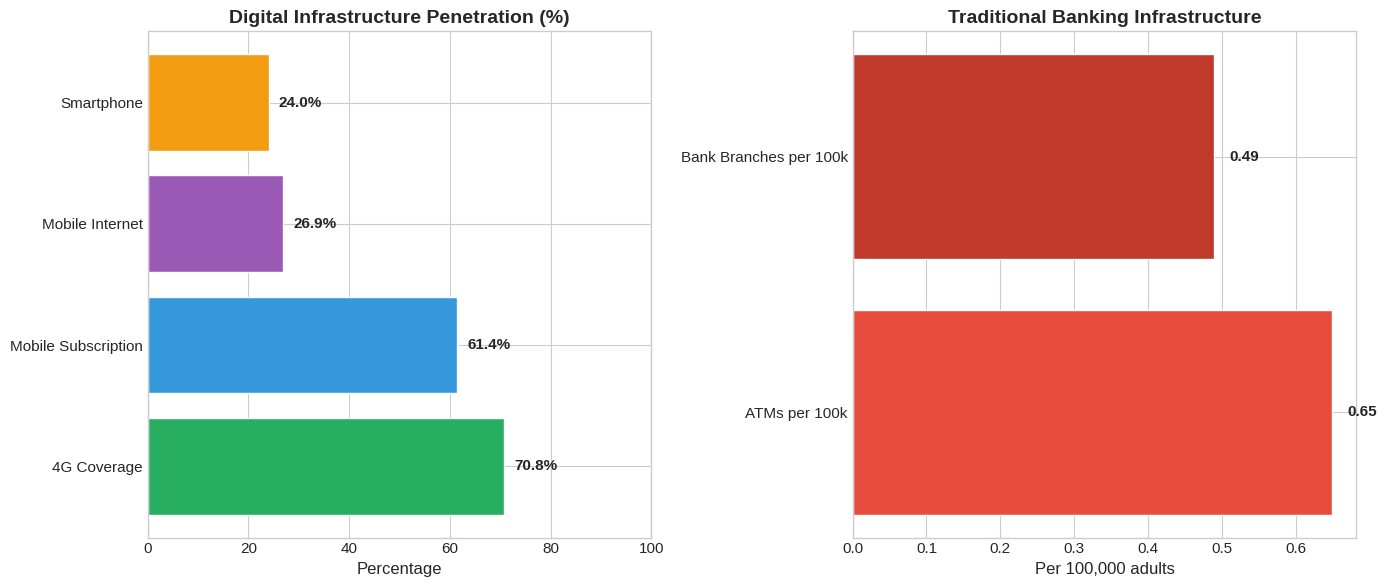


📊 Infrastructure Analysis:
  Digital enablers showing strong growth:
    - 4G coverage doubled: 37.5% → 70.8% (FY22/23 to FY24/25)
    - Mobile subscription: 61.4%

  Bottlenecks remaining:
    - Smartphone: only 24% (limits app-based services)
    - Mobile internet: 26.9% (limits data-intensive apps)
    - Traditional banking: Very sparse (0.49 branches, 0.65 ATMs per 100k)


In [15]:
# Infrastructure data visualization
infra_indicators = ['ACC_4G_COV', 'ACC_MOBILE_PEN', 'ACC_SMARTPHONE', 'ACC_MOBILE_INTERNET']
infra_data = observations[observations['indicator_code'].isin(infra_indicators)].copy()

# Traditional banking infrastructure
bank_indicators = ['ACC_BANK_BRANCHES', 'ACC_ATM_DENSITY']
bank_data = observations[observations['indicator_code'].isin(bank_indicators)]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Digital infrastructure
ax1 = axes[0]
digital_infra = {
    '4G Coverage': 70.8,
    'Mobile Subscription': 61.4,
    'Mobile Internet': 26.9,
    'Smartphone': 24.0
}
colors = ['#27ae60', '#3498db', '#9b59b6', '#f39c12']
bars1 = ax1.barh(list(digital_infra.keys()), list(digital_infra.values()), color=colors, edgecolor='white')
ax1.set_title('Digital Infrastructure Penetration (%)', fontweight='bold')
ax1.set_xlabel('Percentage')
ax1.set_xlim(0, 100)
for bar in bars1:
    ax1.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2, 
             f"{bar.get_width():.1f}%", va='center', fontweight='bold')

# Traditional banking infrastructure
ax2 = axes[1]
bank_infra = {
    'ATMs per 100k': 0.65,
    'Bank Branches per 100k': 0.49
}
bars2 = ax2.barh(list(bank_infra.keys()), list(bank_infra.values()), 
                 color=['#e74c3c', '#c0392b'], edgecolor='white')
ax2.set_title('Traditional Banking Infrastructure', fontweight='bold')
ax2.set_xlabel('Per 100,000 adults')
for bar in bars2:
    ax2.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2, 
             f"{bar.get_width():.2f}", va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/eda_infrastructure.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Infrastructure Analysis:")
print("  Digital enablers showing strong growth:")
print(f"    - 4G coverage doubled: 37.5% → 70.8% (FY22/23 to FY24/25)")
print(f"    - Mobile subscription: 61.4%")
print("\n  Bottlenecks remaining:")
print(f"    - Smartphone: only 24% (limits app-based services)")
print(f"    - Mobile internet: 26.9% (limits data-intensive apps)")
print(f"    - Traditional banking: Very sparse (0.49 branches, 0.65 ATMs per 100k)")

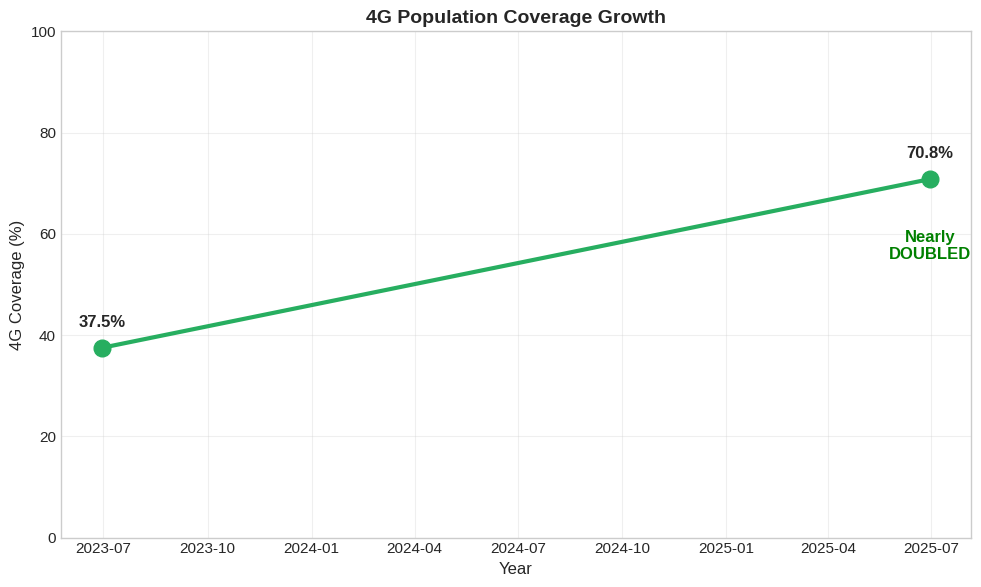


📊 4G Coverage is a LEADING INDICATOR:
  - Precedes mobile money adoption
  - Enables data-based financial services
  - Major investment from both Ethio Telecom and Safaricom


In [16]:
# 4G Coverage growth trend
cov_4g = observations[observations['indicator_code'] == 'ACC_4G_COV'].sort_values('observation_date')

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(cov_4g['observation_date'], cov_4g['value_numeric'], 
        marker='o', markersize=12, linewidth=3, color='#27ae60')

for _, row in cov_4g.iterrows():
    ax.annotate(f"{row['value_numeric']:.1f}%", 
                xy=(row['observation_date'], row['value_numeric']),
                xytext=(0, 15), textcoords='offset points', ha='center', fontweight='bold', fontsize=12)

ax.set_title('4G Population Coverage Growth', fontweight='bold', fontsize=14)
ax.set_xlabel('Year')
ax.set_ylabel('4G Coverage (%)')
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3)

# Add annotation for doubling
ax.annotate('Nearly\nDOUBLED', xy=(cov_4g['observation_date'].iloc[-1], 55), fontsize=12, 
            color='green', fontweight='bold', ha='center')

plt.tight_layout()
plt.savefig('../reports/figures/eda_4g_growth.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 4G Coverage is a LEADING INDICATOR:")
print("  - Precedes mobile money adoption")
print("  - Enables data-based financial services")
print("  - Major investment from both Ethio Telecom and Safaricom")

---
## 5. Event Timeline and Visual Analysis

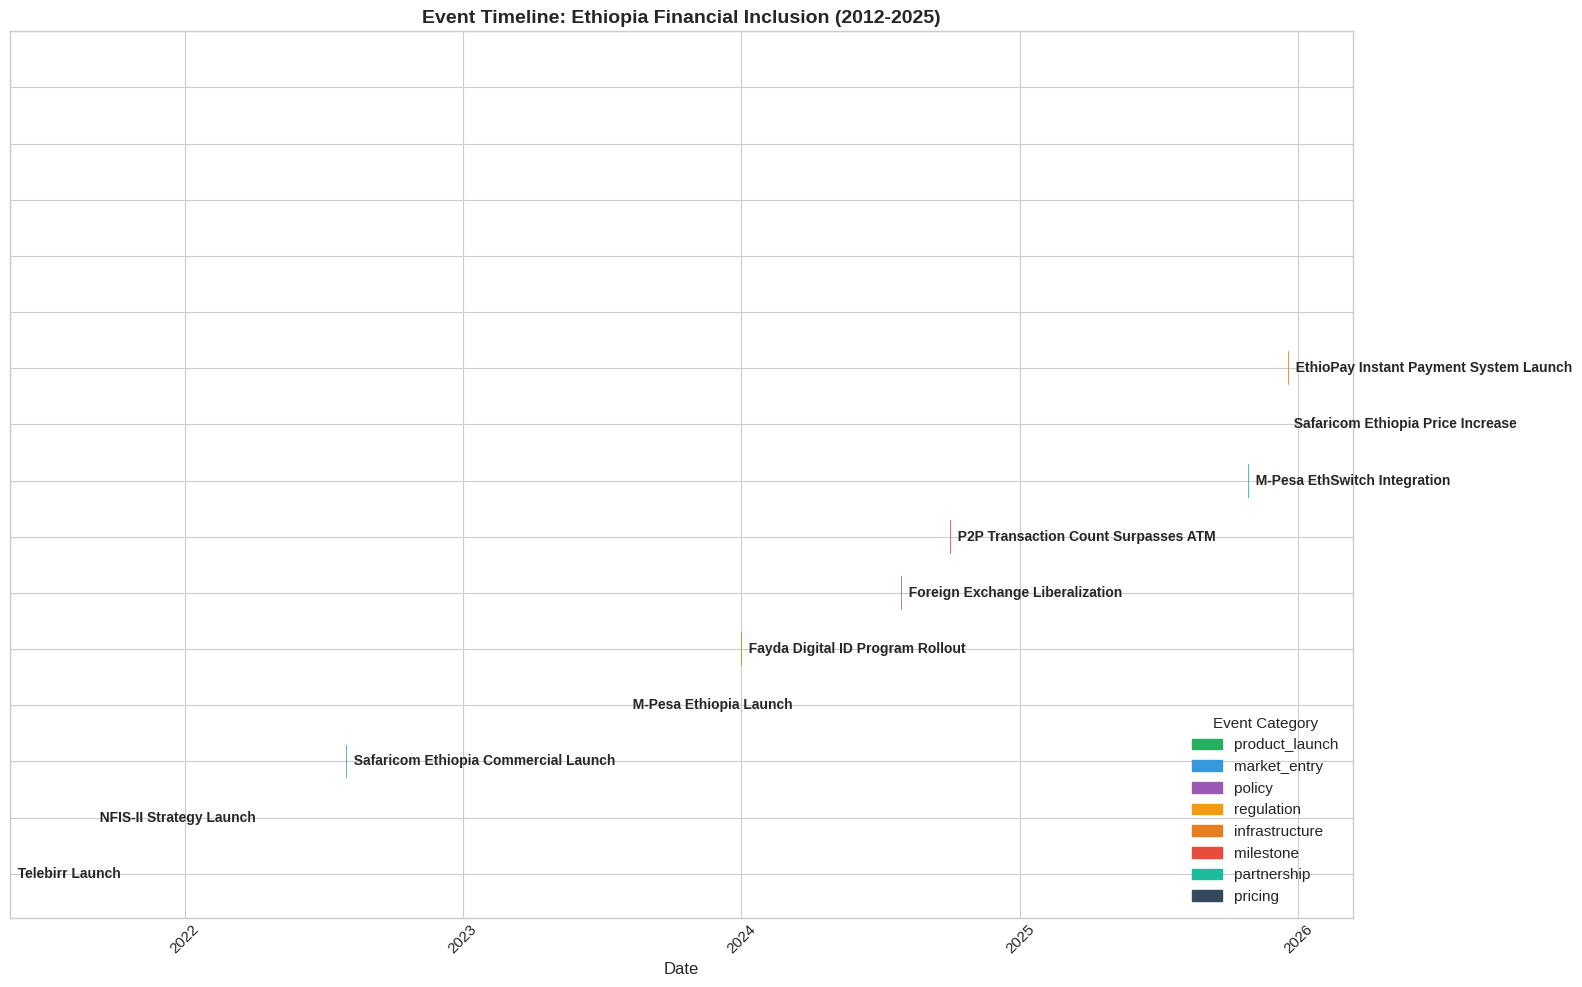

In [17]:
# Create comprehensive event timeline
events_sorted = events.sort_values('observation_date')

fig, ax = plt.subplots(figsize=(16, 10))

# Color by category
category_colors = {
    'product_launch': '#27ae60',
    'market_entry': '#3498db',
    'policy': '#9b59b6',
    'regulation': '#f39c12',
    'infrastructure': '#e67e22',
    'milestone': '#e74c3c',
    'partnership': '#1abc9c',
    'pricing': '#34495e'
}

# Plot events on timeline
y_positions = np.arange(len(events_sorted))

for i, (_, evt) in enumerate(events_sorted.iterrows()):
    color = category_colors.get(evt['category'], '#95a5a6')
    ax.barh(i, 1, left=evt['observation_date'], color=color, height=0.6, alpha=0.8)
    ax.text(evt['observation_date'], i, f"  {evt['indicator']}", 
            va='center', fontsize=10, fontweight='bold')

ax.set_yticks(y_positions)
ax.set_yticklabels(['' for _ in range(len(events_sorted))])
ax.set_xlabel('Date')
ax.set_title('Event Timeline: Ethiopia Financial Inclusion (2012-2025)', fontsize=14, fontweight='bold')

# Add legend
legend_elements = [plt.Rectangle((0,0),1,1, color=color, label=cat) 
                   for cat, color in category_colors.items()]
ax.legend(handles=legend_elements, loc='lower right', title='Event Category')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('../reports/figures/eda_event_timeline.png', dpi=150, bbox_inches='tight')
plt.show()

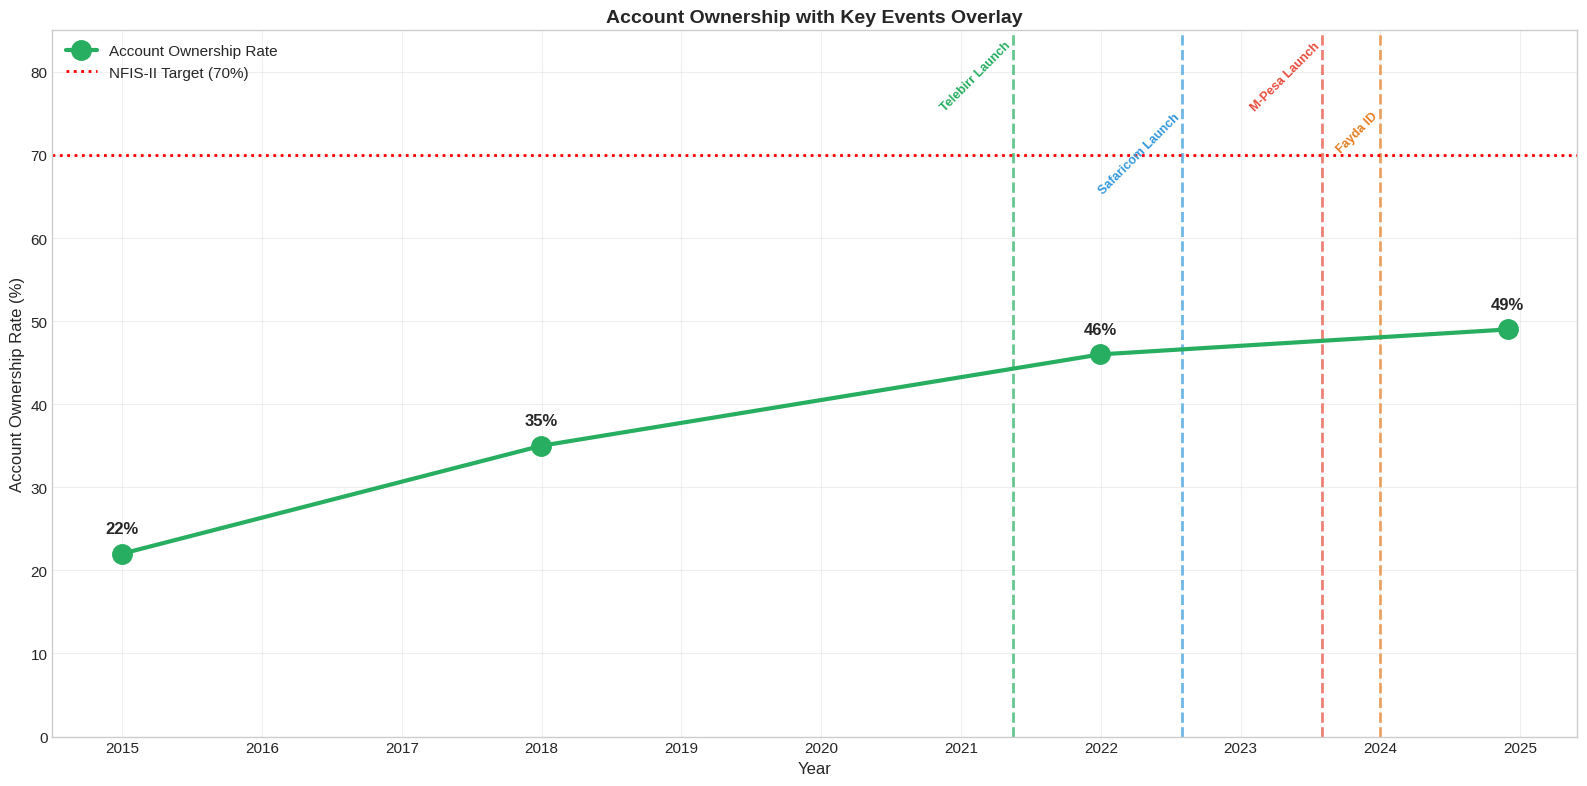


📊 Visual Analysis of Event Impacts:
  ✅ 2014-2017: +13pp growth after Agent Banking Directive
  ✅ 2017-2021: +11pp growth coinciding with CBE Birr and Telebirr launch
  ⚠️ 2021-2024: Only +3pp despite M-Pesa entry and massive Telebirr expansion
  📉 Events appear to have diminishing marginal impact


In [18]:
# Overlay events on account ownership trajectory
fig, ax = plt.subplots(figsize=(16, 8))

# Plot account ownership
acc_ownership_sorted = acc_ownership.sort_values('observation_date')
ax.plot(acc_ownership_sorted['observation_date'], acc_ownership_sorted['value_numeric'], 
        marker='o', markersize=14, linewidth=3, color=COLORS['ACCESS'], 
        label='Account Ownership Rate', zorder=5)

# Add data labels
for _, row in acc_ownership_sorted.iterrows():
    ax.annotate(f"{row['value_numeric']:.0f}%", 
                xy=(row['observation_date'], row['value_numeric']),
                xytext=(0, 15), textcoords='offset points',
                ha='center', fontsize=12, fontweight='bold', zorder=6)

# Add key events as vertical lines with labels
key_events = [
    ('EVT_AGENT_DIR', 'Agent Banking', '#f39c12'),
    ('EVT_CBEBIRR', 'CBE Birr', '#27ae60'),
    ('EVT_NPS_PROC', 'NPS Proclamation', '#9b59b6'),
    ('EVT_TELEBIRR', 'Telebirr Launch', '#27ae60'),
    ('EVT_SAFCOM_LICENSE', 'Safaricom License', '#3498db'),
    ('EVT_SAFARICOM', 'Safaricom Launch', '#3498db'),
    ('EVT_MPESA', 'M-Pesa Launch', '#e74c3c'),
    ('EVT_FAYDA', 'Fayda ID', '#e67e22'),
]

y_offset = 0
for code, name, color in key_events:
    evt = events[events['indicator_code'] == code]
    if not evt.empty:
        date = evt['observation_date'].values[0]
        ax.axvline(x=date, color=color, linestyle='--', alpha=0.7, linewidth=2)
        ax.text(date, 75 - y_offset*5, name, rotation=45, fontsize=9, 
                ha='right', va='bottom', color=color, fontweight='bold')
        y_offset = (y_offset + 1) % 3

# Add NFIS-II target
ax.axhline(y=70, color='red', linestyle=':', linewidth=2, label='NFIS-II Target (70%)')

ax.set_title('Account Ownership with Key Events Overlay', fontsize=14, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Account Ownership Rate (%)')
ax.set_ylim(0, 85)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/eda_events_overlay.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Visual Analysis of Event Impacts:")
print("  ✅ 2014-2017: +13pp growth after Agent Banking Directive")
print("  ✅ 2017-2021: +11pp growth coinciding with CBE Birr and Telebirr launch")
print("  ⚠️ 2021-2024: Only +3pp despite M-Pesa entry and massive Telebirr expansion")
print("  📉 Events appear to have diminishing marginal impact")

---
## 6. Correlation Analysis

In [19]:
# Analyze impact links to understand event-indicator relationships
print("📊 Impact Link Analysis:")
print("=" * 70)

# Join impact links with events
impact_with_events = impact_data.merge(
    events[['record_id', 'indicator', 'category']],
    left_on='parent_id',
    right_on='record_id',
    suffixes=('', '_event')
)

# Summary by pillar
print("\nImpact links by affected pillar:")
print(impact_data['pillar'].value_counts())

# Impact magnitude distribution
print("\nImpact magnitude distribution:")
print(impact_data['impact_magnitude'].value_counts())

# Average lag by relationship type
print("\nAverage lag (months) by relationship type:")
print(impact_data.groupby('relationship_type')['lag_months'].mean().round(1))

📊 Impact Link Analysis:

Impact links by affected pillar:
pillar
ACCESS           8
USAGE            7
AFFORDABILITY    3
GENDER           2
Name: count, dtype: int64

Impact magnitude distribution:
impact_magnitude
medium    11
high       7
low        2
Name: count, dtype: int64

Average lag (months) by relationship type:
relationship_type
direct       7.6
enabling    25.5
indirect    11.2
Name: lag_months, dtype: float64


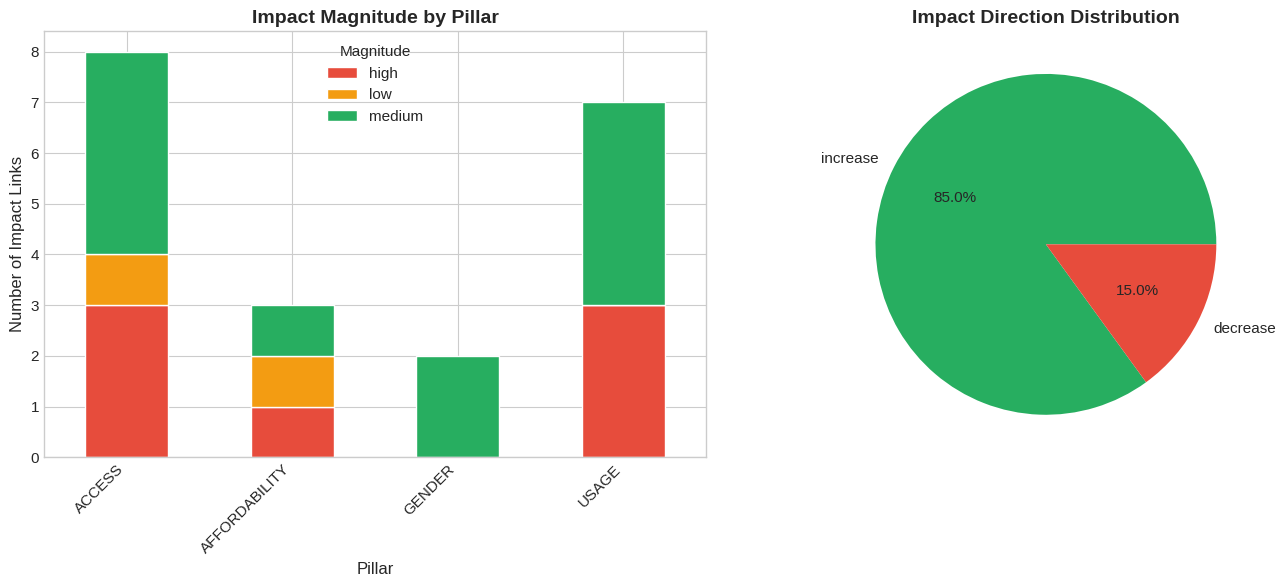

In [20]:
# Create correlation heatmap for impact estimates
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Impact by pillar and magnitude
ax1 = axes[0]
impact_pivot = impact_data.groupby(['pillar', 'impact_magnitude']).size().unstack(fill_value=0)
if len(impact_pivot) > 0:
    impact_pivot.plot(kind='bar', stacked=True, ax=ax1, 
                       color=['#e74c3c', '#f39c12', '#27ae60'], edgecolor='white')
    ax1.set_title('Impact Magnitude by Pillar', fontweight='bold')
    ax1.set_xlabel('Pillar')
    ax1.set_ylabel('Number of Impact Links')
    ax1.legend(title='Magnitude')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Impact direction
ax2 = axes[1]
direction_counts = impact_data['impact_direction'].value_counts()
colors = {'increase': '#27ae60', 'decrease': '#e74c3c', 'mixed': '#f39c12'}
direction_counts.plot(kind='pie', autopct='%1.1f%%', ax=ax2,
                       colors=[colors.get(d, '#95a5a6') for d in direction_counts.index])
ax2.set_title('Impact Direction Distribution', fontweight='bold')
ax2.set_ylabel('')

plt.tight_layout()
plt.savefig('../reports/figures/eda_impact_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [21]:
# Create a matrix showing which events affect which indicators
print("\n📊 Event-Indicator Impact Matrix:")
print("=" * 80)

# Get event-indicator pairs with impact details
for pillar in ['ACCESS', 'USAGE', 'GENDER', 'AFFORDABILITY']:
    pillar_impacts = impact_data[impact_data['pillar'] == pillar]
    if len(pillar_impacts) > 0:
        print(f"\n{pillar}:")
        for _, imp in pillar_impacts.iterrows():
            event = events[events['record_id'] == imp['parent_id']]
            if not event.empty:
                event_name = event['indicator'].values[0]
                direction = '↑' if imp['impact_direction'] == 'increase' else '↓' if imp['impact_direction'] == 'decrease' else '↔'
                magnitude = imp['impact_magnitude'] if pd.notna(imp['impact_magnitude']) else 'N/A'
                estimate = f"{imp['value_numeric']:.0f}%" if pd.notna(imp['value_numeric']) else 'N/A'
                lag = f"{imp['lag_months']:.0f}mo" if pd.notna(imp['lag_months']) else 'N/A'
                print(f"  {event_name[:30]:30} → {imp['related_indicator']:20} {direction} {magnitude:8} ({estimate}, lag: {lag})")


📊 Event-Indicator Impact Matrix:

ACCESS:
  Telebirr Launch                → ACC_OWNERSHIP        ↑ high     (15%, lag: 12mo)
  Safaricom Ethiopia Commercial  → ACC_4G_COV           ↑ medium   (15%, lag: 12mo)
  M-Pesa Ethiopia Launch         → ACC_MM_ACCOUNT       ↑ medium   (5%, lag: 6mo)
  Fayda Digital ID Program Rollo → ACC_OWNERSHIP        ↑ medium   (10%, lag: 24mo)
  National Payment System Procla → ACC_MM_ACCOUNT       ↑ high     (20%, lag: 18mo)
  CBE Birr Mobile Money Launch   → ACC_OWNERSHIP        ↑ low      (3%, lag: 12mo)
  Agent Banking Directive        → ACC_OWNERSHIP        ↑ medium   (8%, lag: 24mo)
  Telecom Sector Liberalization  → ACC_4G_COV           ↑ high     (30%, lag: 36mo)

USAGE:
  Telebirr Launch                → USG_TELEBIRR_USERS   ↑ high     (N/A, lag: 3mo)
  Telebirr Launch                → USG_P2P_COUNT        ↑ high     (25%, lag: 6mo)
  M-Pesa Ethiopia Launch         → USG_MPESA_USERS      ↑ high     (N/A, lag: 3mo)
  M-Pesa EthSwitch Integration  

In [22]:
# Identify potential leading indicators for ACCESS and USAGE
print("\n" + "="*80)
print("🔍 POTENTIAL LEADING INDICATORS")
print("="*80)

print("\n📈 For ACCESS (Account Ownership):")
print("""
Strong Positive Correlation Expected:
  1. 4G Coverage (+70.8% → enables mobile financial services)
  2. Mobile Subscription (+61.4% → basic connectivity)
  3. Mobile Internet (+26.9% → data services)
  4. Fayda Digital ID (15M enrolled → enables KYC)

Constraints/Bottlenecks:
  1. Smartphone Penetration (24% → limits app-based services)
  2. Gender Gap (18-20pp → excludes ~10M women)
  3. Rural Access (38% vs 62% urban → geographic exclusion)
""")

print("\n📈 For USAGE (Digital Payments):")
print("""
Strong Positive Correlation Expected:
  1. Telebirr Users (54.8M → dominant platform)
  2. P2P Transaction Growth (+158% → actual usage behavior)
  3. M-Pesa Active Users (7.1M → competitive pressure)
  4. Agent Network Density (data gap → critical for CICO)

Key Insight from Impact Links:
  - Telebirr shows HIGH impact on USG_P2P_COUNT (25% increase, 6mo lag)
  - M-Pesa Interoperability expected to add +15% active users
  - EthioPay should boost P2P by +15% (based on India UPI experience)
""")


🔍 POTENTIAL LEADING INDICATORS

📈 For ACCESS (Account Ownership):

Strong Positive Correlation Expected:
  1. 4G Coverage (+70.8% → enables mobile financial services)
  2. Mobile Subscription (+61.4% → basic connectivity)
  3. Mobile Internet (+26.9% → data services)
  4. Fayda Digital ID (15M enrolled → enables KYC)

Constraints/Bottlenecks:
  1. Smartphone Penetration (24% → limits app-based services)
  2. Gender Gap (18-20pp → excludes ~10M women)
  3. Rural Access (38% vs 62% urban → geographic exclusion)


📈 For USAGE (Digital Payments):

Strong Positive Correlation Expected:
  1. Telebirr Users (54.8M → dominant platform)
  2. P2P Transaction Growth (+158% → actual usage behavior)
  3. M-Pesa Active Users (7.1M → competitive pressure)
  4. Agent Network Density (data gap → critical for CICO)

Key Insight from Impact Links:
  - Telebirr shows HIGH impact on USG_P2P_COUNT (25% increase, 6mo lag)
  - M-Pesa Interoperability expected to add +15% active users
  - EthioPay should boos

---
## 7. Key Insights Summary

In [23]:
# Document key insights
print("\n" + "="*80)
print("📋 KEY INSIGHTS SUMMARY")
print("="*80)

insights = """
┌─────────────────────────────────────────────────────────────────────────────────┐
│  INSIGHT 1: THE ACCOUNT OWNERSHIP PARADOX                                       │
├─────────────────────────────────────────────────────────────────────────────────┤
│  Finding: Account ownership grew only +3pp (46% → 49%) from 2021-2024 despite   │
│           65M+ mobile money registrations (Telebirr 54.8M + M-Pesa 10.8M)       │
│                                                                                 │
│  Evidence:                                                                      │
│  • Mobile money-only users are rare (~0.5% of adults)                          │
│  • Most MM users already have bank accounts (complementary, not substitute)     │
│  • Activity rate is 66% (many dormant registrations)                           │
│                                                                                 │
│  Implication: MM is deepening usage for existing account holders, not           │
│               bringing in new users. The unbanked population faces structural   │
│               barriers beyond product availability.                             │
└─────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────┐
│  INSIGHT 2: THE DIGITAL CROSSOVER MILESTONE                                     │
├─────────────────────────────────────────────────────────────────────────────────┤
│  Finding: P2P digital transactions surpassed ATM cash withdrawals in FY2024/25  │
│           • P2P: 128.3M transactions (+158% YoY)                               │
│           • ATM: 119.3M transactions (+26% YoY)                                │
│           • Crossover ratio: 1.08                                               │
│                                                                                 │
│  Evidence: EthSwitch Annual Report, historic first-time crossover              │
│                                                                                 │
│  Implication: Ethiopia has reached a tipping point where digital is the         │
│               preferred channel for those already included. Focus should shift  │
│               to reaching the excluded 51%.                                     │
└─────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────┐
│  INSIGHT 3: THE PERSISTENT GENDER GAP                                           │
├─────────────────────────────────────────────────────────────────────────────────┤
│  Finding: Gender gap remains at 18-20pp (56% male vs 36% female in 2021)        │
│           Women hold only 14% of mobile money accounts                          │
│                                                                                 │
│  Evidence:                                                                      │
│  • Mobile phone gender gap: 24% (86% male vs 65% female ownership)             │
│  • Female MM share: 14% (target is 50% by 2030)                                │
│                                                                                 │
│  Implication: Phone access is a binding constraint. Programs must address       │
│               device ownership before financial inclusion.                      │
└─────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────┐
│  INSIGHT 4: INFRASTRUCTURE AS LEADING INDICATOR                                 │
├─────────────────────────────────────────────────────────────────────────────────┤
│  Finding: 4G coverage doubled (37.5% → 70.8%) and is a strong leading indicator │
│                                                                                 │
│  Evidence:                                                                      │
│  • 4G enables data-intensive mobile money apps                                  │
│  • Telecom liberalization driving investment                                    │
│  • 12-36 month lag between infrastructure and adoption (per impact links)       │
│                                                                                 │
│  Bottleneck: Smartphone (24%) and mobile internet (26.9%) still low             │
│                                                                                 │
│  Implication: Infrastructure improvements create conditions for growth          │
│               but don't guarantee adoption. Device affordability is key.        │
└─────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────┐
│  INSIGHT 5: NFIS-II TARGET GAP                                                  │
├─────────────────────────────────────────────────────────────────────────────────┤
│  Finding: Ethiopia is 21pp short of the NFIS-II target (49% vs 70% by 2025)     │
│                                                                                 │
│  Evidence:                                                                      │
│  • At current trajectory (+1pp/year), would reach 70% by 2046                  │
│  • Telebirr growth is flattening (market saturation of bankable population)     │
│  • Structural barriers (gender, rural, device) require policy intervention      │
│                                                                                 │
│  Implication: Achieving 70% requires reaching structurally excluded groups      │
│               through targeted interventions (G2P digitization, Fayda-linked    │
│               accounts, women-focused programs).                                │
└─────────────────────────────────────────────────────────────────────────────────┘
"""
print(insights)


📋 KEY INSIGHTS SUMMARY

┌─────────────────────────────────────────────────────────────────────────────────┐
│  INSIGHT 1: THE ACCOUNT OWNERSHIP PARADOX                                       │
├─────────────────────────────────────────────────────────────────────────────────┤
│  Finding: Account ownership grew only +3pp (46% → 49%) from 2021-2024 despite   │
│           65M+ mobile money registrations (Telebirr 54.8M + M-Pesa 10.8M)       │
│                                                                                 │
│  Evidence:                                                                      │
│  • Mobile money-only users are rare (~0.5% of adults)                          │
│  • Most MM users already have bank accounts (complementary, not substitute)     │
│  • Activity rate is 66% (many dormant registrations)                           │
│                                                                                 │
│  Implication: MM is deepening usage for existing ac

In [24]:
# Data quality and limitations
print("\n" + "="*80)
print("⚠️ DATA QUALITY ASSESSMENT & LIMITATIONS")
print("="*80)

limitations = """
1. SPARSE TIME SERIES
   • Findex data only available every 3 years (2011, 2014, 2017, 2021, 2024)
   • Limits traditional time series forecasting approaches
   • Requires event-based intervention modeling

2. SURVEY vs. SUPPLY-SIDE DATA MISMATCH
   • Findex (demand-side): 49% account ownership
   • Operator data (supply-side): 65M+ registrations
   • Gap explained by: dormancy, overlap, multiple accounts per person

3. MISSING DATA POINTS
   • Agent network density (critical for CICO infrastructure)
   • Transaction frequency per user
   • Regional disaggregation for most indicators
   • Credit/savings product penetration

4. CONFIDENCE LEVELS
   • High confidence: {high_pct:.1f}%
   • Medium confidence: {med_pct:.1f}%
   • Some urban/rural estimates are medium confidence

5. TEMPORAL ALIGNMENT
   • Findex 2024 surveyed Oct-Nov 2024
   • Operator data often on Ethiopian fiscal year (July-June)
   • Impact lags vary (3-36 months depending on intervention)
""".format(
    high_pct=observations[observations['confidence']=='high'].shape[0]/len(observations)*100,
    med_pct=observations[observations['confidence']=='medium'].shape[0]/len(observations)*100
)
print(limitations)


⚠️ DATA QUALITY ASSESSMENT & LIMITATIONS

1. SPARSE TIME SERIES
   • Findex data only available every 3 years (2011, 2014, 2017, 2021, 2024)
   • Limits traditional time series forecasting approaches
   • Requires event-based intervention modeling

2. SURVEY vs. SUPPLY-SIDE DATA MISMATCH
   • Findex (demand-side): 49% account ownership
   • Operator data (supply-side): 65M+ registrations
   • Gap explained by: dormancy, overlap, multiple accounts per person

3. MISSING DATA POINTS
   • Agent network density (critical for CICO infrastructure)
   • Transaction frequency per user
   • Regional disaggregation for most indicators
   • Credit/savings product penetration

4. CONFIDENCE LEVELS
   • High confidence: 85.0%
   • Medium confidence: 15.0%
   • Some urban/rural estimates are medium confidence

5. TEMPORAL ALIGNMENT
   • Findex 2024 surveyed Oct-Nov 2024
   • Operator data often on Ethiopian fiscal year (July-June)
   • Impact lags vary (3-36 months depending on intervention)



In [25]:
# Hypotheses for impact modeling
print("\n" + "="*80)
print("🔬 HYPOTHESES FOR IMPACT MODELING (Task 3)")
print("="*80)

hypotheses = """
HYPOTHESIS 1: Diminishing Returns from Mobile Money
  H₀: Each new mobile money entrant has smaller marginal impact on account ownership
  Evidence: Telebirr (+11pp period) vs M-Pesa (+3pp period)
  Test: Compare impact coefficients across product launches

HYPOTHESIS 2: Infrastructure Threshold Effect
  H₀: 4G coverage must exceed 50% before mobile money adoption accelerates
  Evidence: 4G grew from 37.5% to 70.8%, coinciding with P2P crossover
  Test: Structural break analysis around coverage thresholds

HYPOTHESIS 3: Gender-Device Constraint
  H₀: Closing the gender gap requires addressing phone ownership first
  Evidence: 24% mobile phone gap vs 18-20% account gap
  Test: Cross-country comparison of phone-to-inclusion pathways

HYPOTHESIS 4: P2P-Led Usage Growth
  H₀: P2P is the gateway use case; merchant/bill payments follow with 12-24mo lag
  Evidence: P2P dominates transactions (128.3M), Ethiopia's unique P2P-for-commerce pattern
  Test: Granger causality between P2P growth and other payment channels

HYPOTHESIS 5: Interoperability Acceleration
  H₀: EthSwitch interoperability (Oct 2025) will accelerate network effects
  Evidence: Tanzania saw +20% usage after interoperability
  Test: Pre/post intervention analysis for M-Pesa EthSwitch integration
"""
print(hypotheses)


🔬 HYPOTHESES FOR IMPACT MODELING (Task 3)

HYPOTHESIS 1: Diminishing Returns from Mobile Money
  H₀: Each new mobile money entrant has smaller marginal impact on account ownership
  Evidence: Telebirr (+11pp period) vs M-Pesa (+3pp period)
  Test: Compare impact coefficients across product launches

HYPOTHESIS 2: Infrastructure Threshold Effect
  H₀: 4G coverage must exceed 50% before mobile money adoption accelerates
  Evidence: 4G grew from 37.5% to 70.8%, coinciding with P2P crossover
  Test: Structural break analysis around coverage thresholds

HYPOTHESIS 3: Gender-Device Constraint
  H₀: Closing the gender gap requires addressing phone ownership first
  Evidence: 24% mobile phone gap vs 18-20% account gap
  Test: Cross-country comparison of phone-to-inclusion pathways

HYPOTHESIS 4: P2P-Led Usage Growth
  H₀: P2P is the gateway use case; merchant/bill payments follow with 12-24mo lag
  Evidence: P2P dominates transactions (128.3M), Ethiopia's unique P2P-for-commerce pattern
  Tes

In [26]:
# Save summary to file
summary_output = """
# Task 2: Exploratory Data Analysis - Summary Report

## Dataset Overview
- Total records: {total_records}
- Observations: {obs_count}
- Events: {event_count}
- Impact Links: {impact_count}
- Temporal Range: 2011-2025

## Key Metrics (2024)
- Account Ownership: 49% (NFIS-II target: 70%)
- Mobile Money Account Rate: 9.45%
- Digital Payment Usage: 35%
- Gender Gap: 18-20pp
- Urban-Rural Gap: 24pp

## Key Insights

### 1. The Account Ownership Paradox
Despite 65M+ mobile money registrations, account ownership only grew +3pp (2021-2024).
Mobile money is complementary to existing bank accounts, not reaching new users.

### 2. The Digital Crossover Milestone
P2P transactions surpassed ATM withdrawals in FY2024/25 (128.3M vs 119.3M).
This is a historic first for Ethiopia.

### 3. Persistent Gender Gap
18-20pp gap in account ownership. Women hold only 14% of mobile money accounts.
Phone ownership is a binding constraint (24% mobile gender gap).

### 4. Infrastructure as Leading Indicator
4G coverage doubled to 70.8%. However, smartphone (24%) and mobile internet (26.9%)
remain bottlenecks.

### 5. NFIS-II Target Gap
21pp gap to 70% target. At current trajectory (+1pp/year), would reach 70% by 2046.

## Data Limitations
- Sparse Findex data (every 3 years)
- Survey vs supply-side data mismatch
- Missing agent network density
- Limited regional disaggregation

## Next Steps
Proceed to Task 3 (Forecasting) with event-based intervention modeling.

---
Generated: {date}
""".format(
    total_records=len(main_data),
    obs_count=len(observations),
    event_count=len(events),
    impact_count=len(impact_data),
    date=datetime.now().strftime('%Y-%m-%d')
)

with open('../reports/eda_summary_report.md', 'w') as f:
    f.write(summary_output)

print("✅ Summary report saved to reports/eda_summary_report.md")
print("\n" + "="*80)
print("EDA COMPLETE - Ready for Task 3: Forecasting")
print("="*80)

✅ Summary report saved to reports/eda_summary_report.md

EDA COMPLETE - Ready for Task 3: Forecasting
